# Курс по машинному обучению,   ВМК МГУ
## SVM

### Важно! О формате сдачи

* **Практически все выделенные задания из ноутбука оцениваются по системе <font color='red'>кросс-рецензирования</font>. Задания, в котором надо реализовать свой код и послать в систему, выделены здесь и в pdf отдельно**
* **В этом задании есть новый тип задания -- ML-решение**
* **При решении ноутбука используйте данный шаблон. Не нужно удалять текстовые ячейки c разметкой частей ноутбука и формулировками заданий. Добавлять свои ячейки, при необходимости, конечно можно**
* **Везде, где в формулровке задания есть какой-либо вопрос (или просьба вывода), необходимо прописать ответ в ячейку (код или markdown).**
* **Наличие кода решения обязательно. Письменные ответы на вопросы без сопутствующего кода оцениваются в 0 баллов.**

### Важно!

**Перед тем, как сдать ноутбук на кросс-рецензирование, мы рекомендуем перезапустить ядро и выполнить весь ноутбук (cell -> run all). При правильном выполнении весь процесс работы ноутбука не должен занять больше 20 минут**

__В этом задании вы..:__

- Изучите работу модели SVM
- Поймете, как с её помощью можно строить нелинейные разделяющие поверхности
- Потренируетесь в подборе оптимальных параметров на обучающей выборке для достижения наилучшего качества на закрытой выборке (ML-решение)
- Узнаете про метод, который позволяет понижать число признаков и изучите его особенности на практике
- Научитесь корректировать выход модели SVM-классификатора, чтобы уметь получать вероятности

**А также..**

Если в ячейке написана фраза "Вывод", то ожидается ответ в виде текста (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если в ячейке написано "Your code here", то ожидается ответ в виде кода (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если есть и ячейка с фразой "Вывод", и ячейка с фразой "Your code here", то в ответе ожидается и код, и текст)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from copy import copy

Если Вы дальтоник, то можете воспользоваться готовой colormap из matplotlib (или найти свою):
```
plt.style.use('tableau-colorblind10')
```

In [2]:
from matplotlib.colors import ListedColormap

from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate, train_test_split
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score
from sklearn.datasets import make_blobs, make_circles, make_moons

In [3]:
def make_moons_cls(size=1000, d=2):
    X, y = make_moons(n_samples=size, noise=0.15)
    if d > 2:
        X = np.concatenate((X, np.random.normal(size=(size, d-2))), axis=1)
    return X, y

def make_circles_cls():
    X, y = make_circles()
    
def generate_data_with_imb_classes(size1=100, size2=10):
    X = np.r_[(
        np.random.normal(size=(size1, 2)),
        np.random.normal(loc=2.0, size=(size2, 2))
    )]
    
    y = np.ones(len(X))
    y[-size2:] = 0
    return X, y

In [4]:
def plot_separating_surface(X, y, cls, view_support=False, title=''):
    x_min = min(X[:, 0]) - 0.1
    x_max = max(X[:, 0]) + 0.1
    y_min = min(X[:, 1]) - 0.1
    y_max = max(X[:, 1]) + 0.1
    h = 0.005
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
    Z = cls.predict(np.c_[xx.ravel(), yy.ravel()])

    plt.figure(figsize=(10, 10))
    if title:
        plt.title(title)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', s=40, cmap=cm_bright)
    if view_support:
        plt.scatter(X[cls.support_, 0], X[cls.support_, 1], 
                    c=y[cls.support_], edgecolors='k', s=150, cmap=cm_bright)
    Z = Z.reshape(xx.shape)
    plt.xticks(())
    plt.yticks(())
    plt.contourf(xx, yy, Z, cmap=cm, alpha=.3)
    plt.show()

# 1. Разделяющая поверхность (1 балл)

В ячейке ниже генерируется выборка, состоящая из объектов двух классов. Каждый объект представлен двумя координатами, так что объекты этой выборки можно отобразить на плоскости, используя функцию scatter из библиотеки matplotlib.
    
В этом задании вам надо будет обучить линейную разделяющую поверхность с помощью $\mbox{sklearn.svm.SVC(kernel='linear')}$, а также нелинейную c rbf-ядром с помощью $\mbox{sklearn.svm.SVC(kernel='rbf')}$. Остальные параметры методов можете оставить дефолтными. Делить выборку на обучение и валидацию сейчас не требуется, так как нас будет пока интересовать только форма разделяющей кривой.

In [5]:
X, y = make_moons_cls()
linear_svc = SVC(kernel='linear')
nonlinear_svc = SVC(kernel='rbf')

Визуализируем выборку

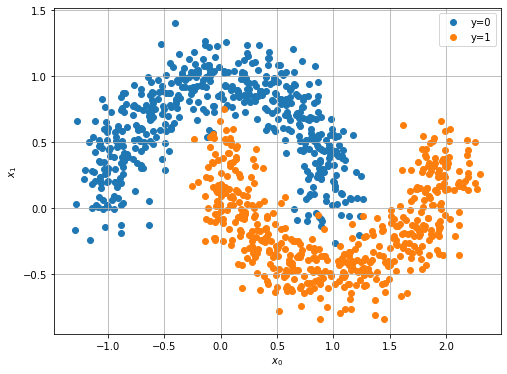

In [6]:
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0, 0], X[y == 0, 1], label='y=0')
plt.scatter(X[y == 1, 0], X[y == 1, 1], label='y=1')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.legend()
plt.grid()

Обучите модели и визуализируйте разделяющую поверхность для обеих моделей с помощью функции plot_separating_surface(). Посчитайте точность (accuracy) на обучающей выборке для каждой из моделей.

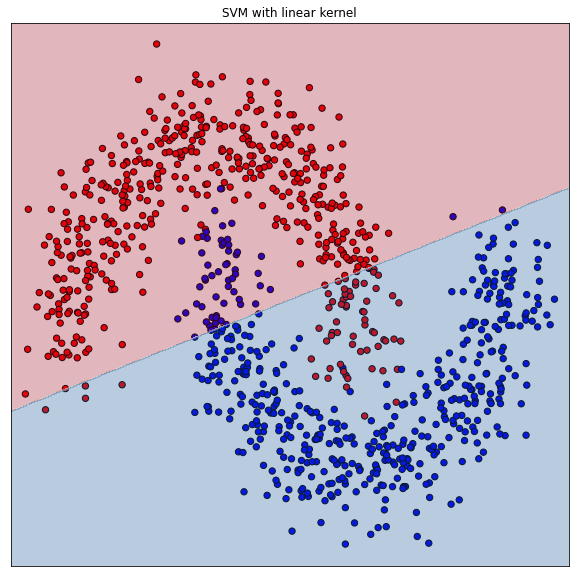

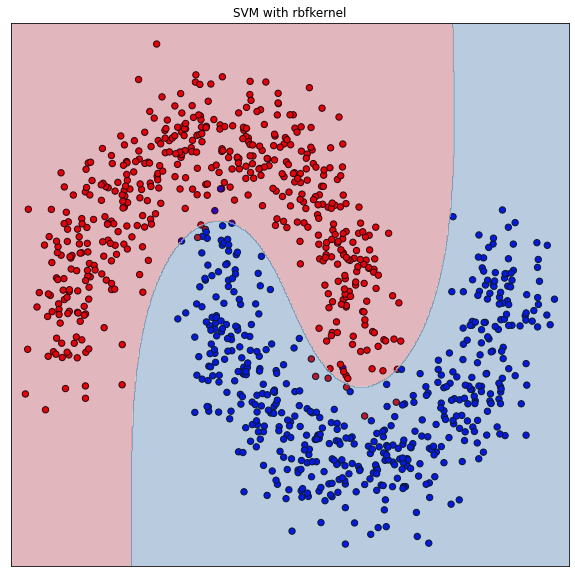

In [7]:
# Your code here
from sklearn.preprocessing import StandardScaler
scaller = StandardScaler()
X_scaled = scaller.fit_transform(X)

linear_svc.fit(X, y)
nonlinear_svc.fit(X, y)

plot_separating_surface(X, y, linear_svc, title='SVM with linear kernel')
plot_separating_surface(X, y, nonlinear_svc, title='SVM with rbfkernel')



Сделайте вывод
о получившихся результатах. Какая из моделей лучше подходит для данной выборки и почему? 

**Вывод:** модель с ядром rbf подходит лучше, потому что изначально выборка неразделима линейно 

# 2. Опорные объекты (2 балла)

Продолжаем работать с выборкой и моделями из первой части. Для линейной и rbf-моделей рассмотрим 
    опорные объекты, полученные после обучения. Визуализировать их можно, используя функуцию plot_separating_surface с параметром vis_support=True. Достать опорные объекты из обученной модели можно с помощью поля model.support_.

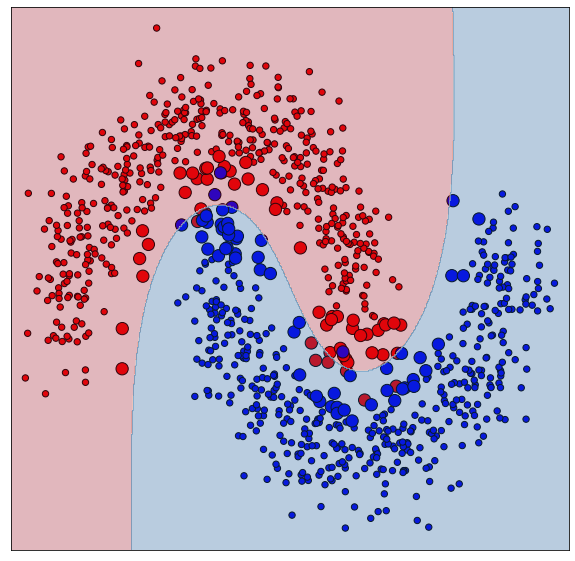

In [8]:
plot_separating_surface(X, y, nonlinear_svc, view_support=True)

**Пункт 1**
Обучите новые две модели $\mbox{SVC(kernel='rbf')}$, используя только опорные объекты построенные с помощью соответственно линейной (linear_svc) и нелинейной (nonlinear_svc) моделей из первой части.

In [9]:
svc_on_linear_support = SVC(kernel='rbf')
svc_on_rbf_support = SVC(kernel='rbf')

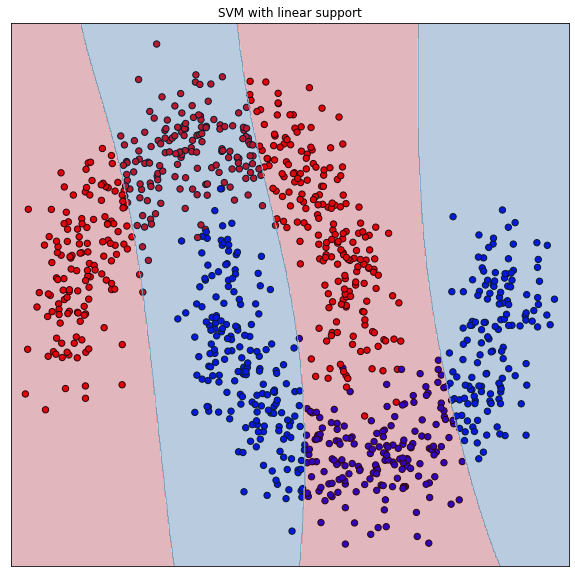

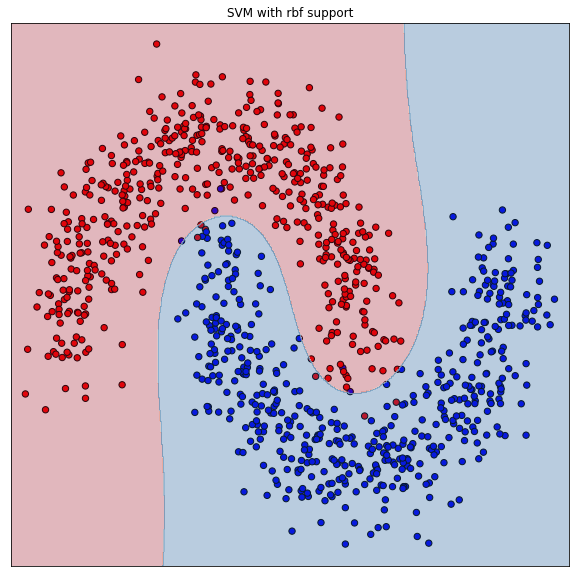

In [10]:
# Your code here
#опорные объекты с линейным ядром
X_linear_support = X[linear_svc.support_, :]
y_linear_support = y[linear_svc.support_]

#опорные с ядром rbf
X_nonlinear_support = X[nonlinear_svc.support_, :]
y_nonlinear_support = y[nonlinear_svc.support_]

#обучение
svc_on_linear_support.fit(X_linear_support, y_linear_support)
svc_on_rbf_support.fit(X_nonlinear_support, y_nonlinear_support)

#визуализация
plot_separating_surface(X, y, svc_on_linear_support, title='SVM with linear support')
plot_separating_surface(X, y, svc_on_rbf_support, title='SVM with rbf support')



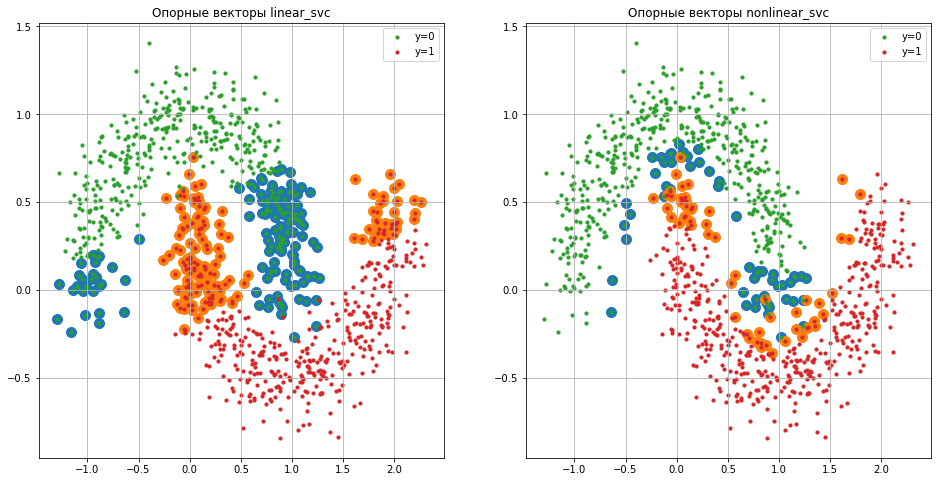

In [11]:
#более мужицкие графики для проверяющего
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(16)    #  ширина и
fig.set_figheight(8)    #  высота "Figure"

axes[0].scatter(X_linear_support[y_linear_support == 0, 0], X_linear_support[y_linear_support == 0, 1], s=100)
axes[0].scatter(X_linear_support[y_linear_support == 1, 0], X_linear_support[y_linear_support == 1, 1], s=100)

axes[1].scatter(X_nonlinear_support[y_nonlinear_support == 0, 0], X_nonlinear_support[y_nonlinear_support == 0, 1], s=100)
axes[1].scatter(X_nonlinear_support[y_nonlinear_support == 1, 0], X_nonlinear_support[y_nonlinear_support == 1, 1], s=100)

for ax in axes:
    ax.scatter(X[y == 0, 0], X[y == 0, 1], label='y=0', s=10)
    ax.scatter(X[y == 1, 0], X[y == 1, 1], label='y=1', s=10)

    ax.legend()
    ax.grid()
    
    
axes[0].set_title("Опорные векторы linear_svc")
axes[1].set_title("Опорные векторы nonlinear_svc")


plt.show()



Сравните полученные разделяющие поверхности с нелинейной моделью (nonlinear_svc) из первой части. Какая из поверхностей больше похожа на нелинейнную модель из первой части и почему, опишите в выводе. 

**Вывод:** больше похожа та, которая обучалась на опорных векторах модели с ядром rbf (svc_on_rbf_support), так как ее опорные векторы сохранили структуру границ классов, а вторая обучалась на объектах , которые были опорными для линии и получилось 4 безформенные кучки

**Пункт 2** Обучите модель $\mbox{SVC(kernel='rbf')}$, используя все объекты кроме тех, что являлись опорными для нелинейной модели из первой части (nonlinear_svc) и сравните эту модель вместе с svc_on_rbf_support с нелинейной моделью из первой части (nonlinear_svc). Визуализируйте разделяющие поверхности обеих моделей.

In [12]:
svc_all_without_rbf_support = SVC(kernel='rbf')

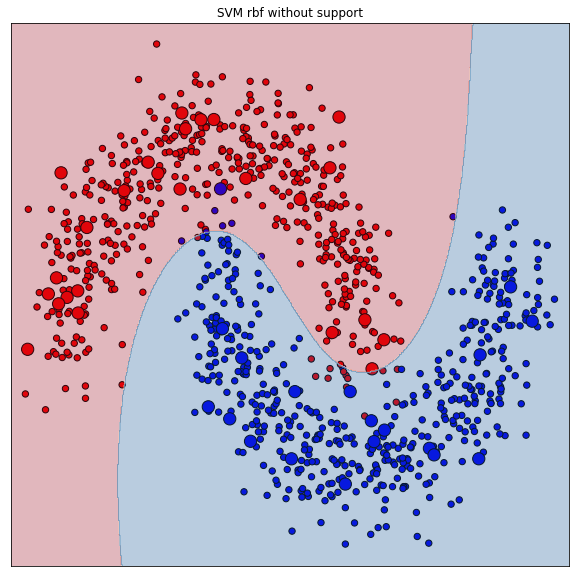

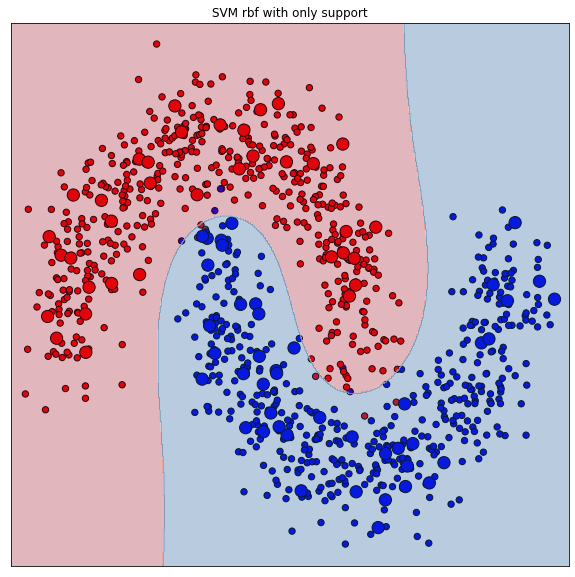

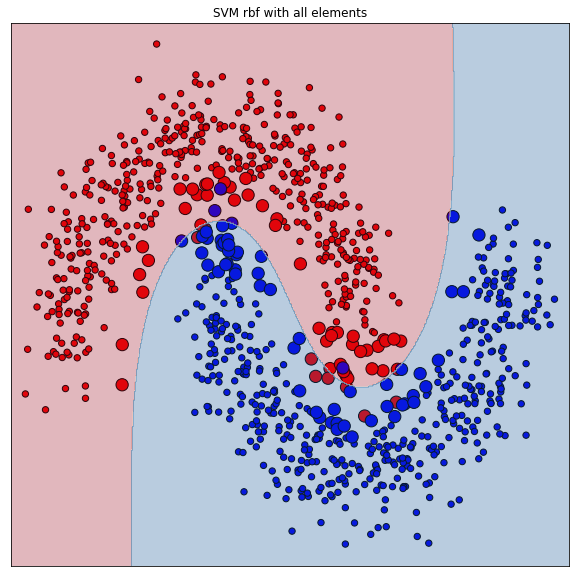

In [13]:
# Your code here

#объекты кроме тех, что являлись опорными
X_without_nonlinear_support = np.delete(X, nonlinear_svc.support_, axis=0)
y_without_nonlinear_support = np.delete(y, nonlinear_svc.support_, axis=0)

#обучение
svc_all_without_rbf_support.fit(X_without_nonlinear_support, y_without_nonlinear_support)

#визуализация
plot_separating_surface(X, y, svc_all_without_rbf_support, view_support=True, title='SVM rbf without support')
plot_separating_surface(X, y, svc_on_rbf_support, view_support=True, title='SVM rbf with only support')
plot_separating_surface(X, y, nonlinear_svc, view_support=True, title='SVM rbf with all elements')



Сильно ли полученные поверхности отличаются от той, что была получена в первой части? Что произошло с пограничными объектами? Объясните полученные результаты.

**Вывод:** поверхности отличаются не сильно. В случае обучения на данных без опорных, опорными стали те, что в толще класса, то есть убрав авангард у нас появился следующий ряд и это почти не повлияло на форму границы, так как SVM устойчив к регуляризации(расширению полосы между классами), а здесь по сути это и сделали. В случае обучения только на опорных граница почти не изменилась, так как опорные сохранили структуру границы между классами

# 3. Форма разделяющей поверхности для несбалансированных классов (3 балла)

Формы разделяющих поверхностей могут быть вариативными для нелинейного случая. Один из способов влиять на форму поверхности -- это веса классов, которые задаются через параметр class_weight в sklearn.svm.SVC. Особенно это может быть полезно в задачах, где известно, что распределение классов в обучающей выборке отличается от реального. Такое свойственно медицинским данным, где в обучающих данных часто наблюдается перекос в сторону больных, так как именно их данные чаще собираются.
    
В данном задании вам будет дана выборка с несбалансированными данными. Кроме того, дана вторая выборка,
в которой классы имеют то же распределение, но классы имеют другое соотношение.  Вам нужно построить различные rbf-модели, меняя параметры весов классов и визуализировать разделяющие поверхности. Попробуйте улучшить 
качество на второй выборке (X_distr2, y_distr2), обучаясь только на первой (X_distr1, y_distr1) меняя параметры весов классов относительно дефолтных: class_weight={1: 1.0, 0: 1.0}.

In [45]:
X_distr1, y_distr1 = generate_data_with_imb_classes(100, 10)
X_distr2, y_distr2 = generate_data_with_imb_classes(10, 100)
from sklearn.metrics import accuracy_score


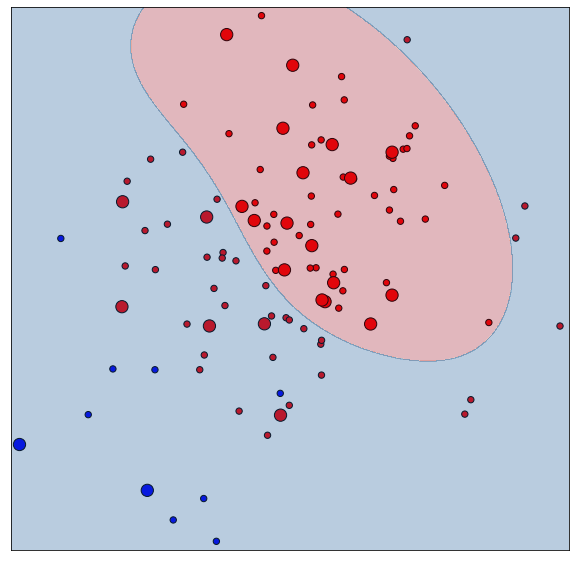

Точность с дефолтными весами: 0.6272727272727273


In [46]:
# Модель с дефолтными параметрами, которую Вам предстоит улучшить
base_model = SVC()
base_model.fit(X_distr1, y_distr1)
plot_separating_surface(X_distr2, y_distr2, base_model, view_support=True)
print("Точность с дефолтными весами:", accuracy_score(y_distr2, base_model.predict(X_distr2)))

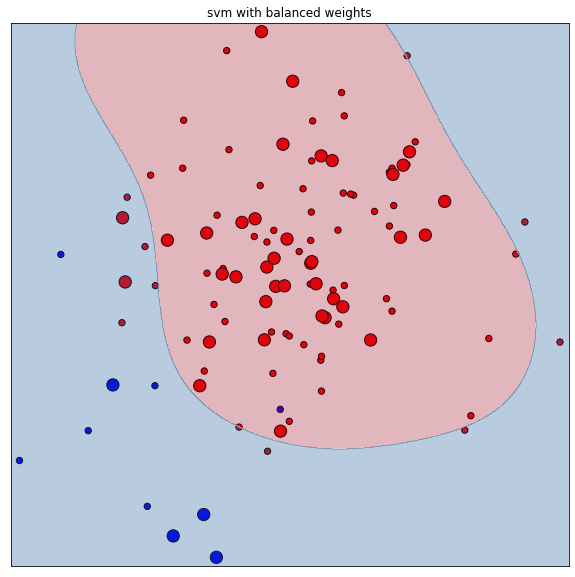

Точность с балансированными весами: 0.8818181818181818


In [47]:
# Your code here
balanced_model = SVC(class_weight='balanced')
balanced_model.fit(X_distr1, y_distr1)
plot_separating_surface(X_distr2, y_distr2, balanced_model, view_support=True, title="svm with balanced weights")
print("Точность с балансированными весами:", accuracy_score(y_distr2, balanced_model.predict(X_distr2)))


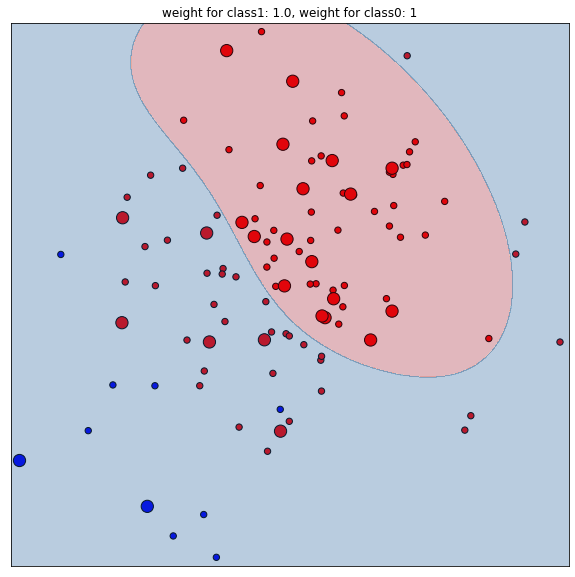

Точность: 0.6272727272727273


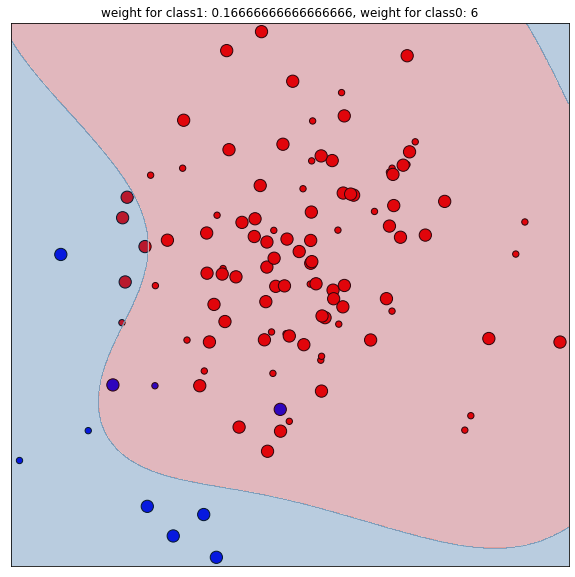

Точность: 0.9272727272727272


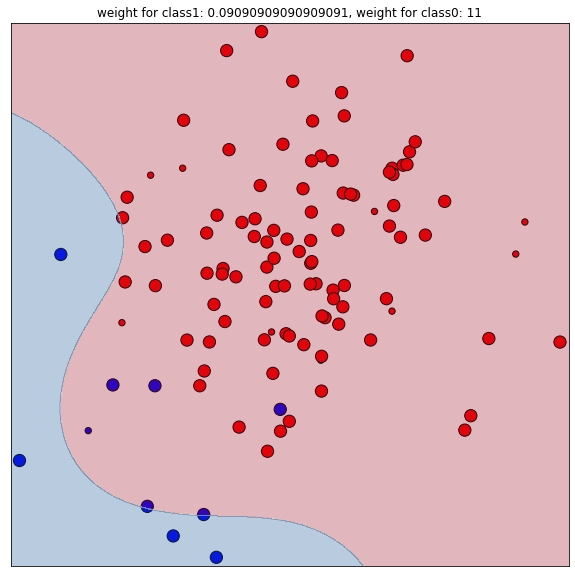

Точность: 0.9454545454545454


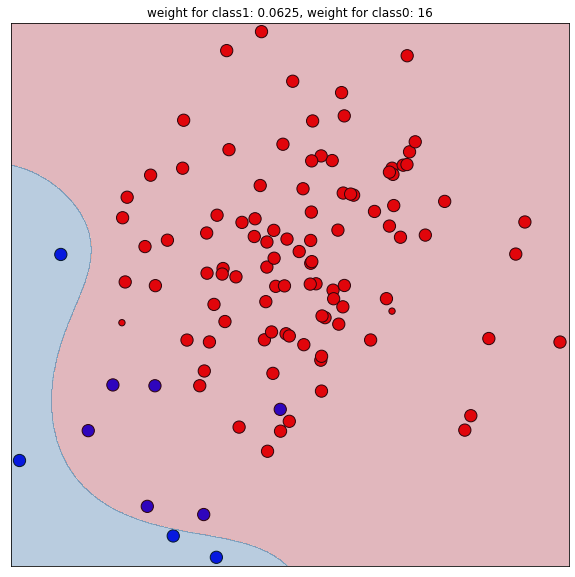

Точность: 0.9454545454545454


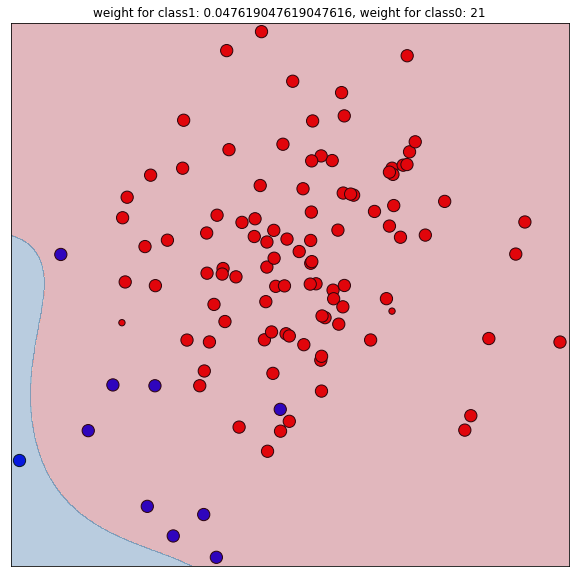

Точность: 0.9181818181818182


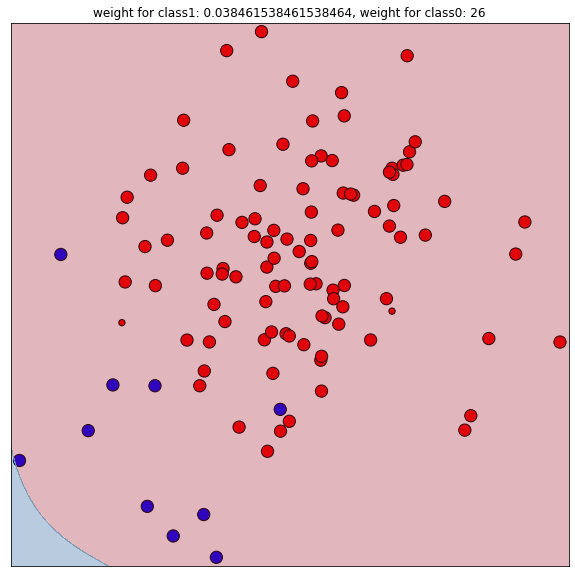

Точность: 0.9090909090909091


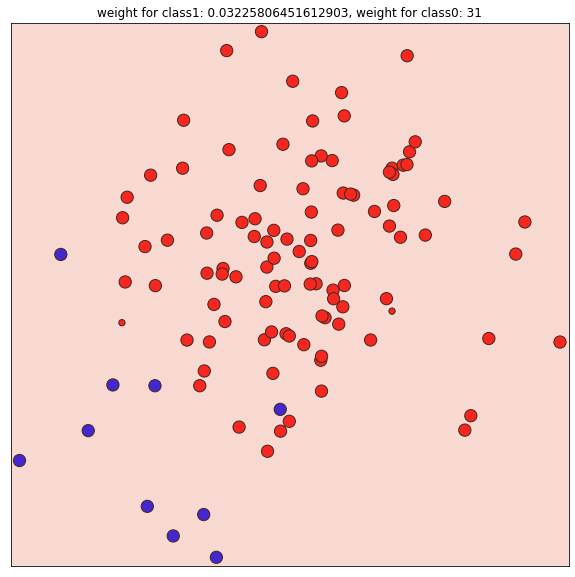

Точность: 0.9090909090909091


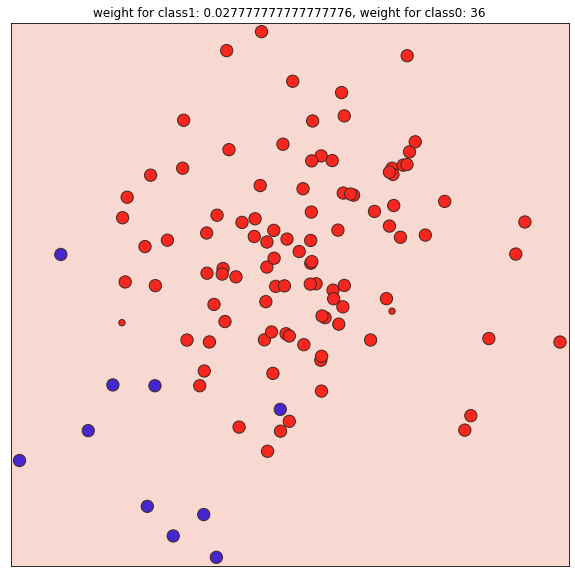

Точность: 0.9090909090909091


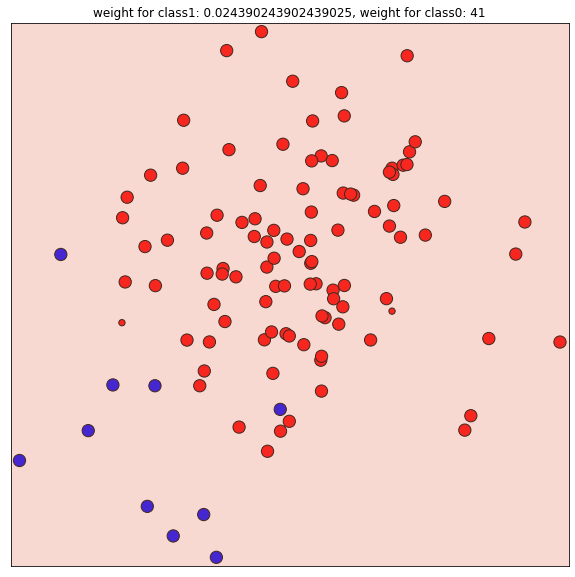

Точность: 0.9090909090909091


In [48]:
freq_0 = y_distr1[y_distr1 == 0].sum() / y_distr1.shape[0]
freq_1 = y_distr1[y_distr1 == 1].sum() / y_distr1.shape[0]

score = {}
for i in range(1,42,5):
    my_model = SVC(class_weight={1: 1/i, 0: i})
    my_model.fit(X_distr1, y_distr1)
    plot_separating_surface(X_distr2, y_distr2, my_model, view_support=True, title=f"weight for class1: {1/i}, weight for class0: {i}")
    score[(1/i, i)] = accuracy_score(y_distr2, my_model.predict(X_distr2))
    print("Точность:", score[(1/i, i)])

In [53]:
#Лучшие параметры            
max_val = max(score.values())
best_param = {k:v for k, v in score.items() if v == max_val}
print('самые вкусные веса для класса 1 и 0 соответсвенно', best_param)
#если чо синие это 1, красные это 0

самые вкусные веса для класса 1 и 0 соответсвенно {(0.09090909090909091, 11): 0.9454545454545454, (0.0625, 16): 0.9454545454545454}


# 4. Обучите лучшую SVM модель (контест, 20 баллов)

Возможность строить нелинейные поверхности может сильно улучшить качество, но и несет риск переобучения. 
    В этом задании предстоит обучить лучшую svm модель и получить хорошее качество на тесте в системе тестирования. Для контроля переобучения рекомендуется пользоваться кросс-валидацией. Для улучшения качества рекомендуется подбирать

1. параметр регуляризации C;
2. тип разделяющей кривой linear/rbf/poly;
3. степень в случае разделяющей кривой poly.

Также не забывайте, что при решении задач машинного обучения полезно смотреть в данные :) 

**Данные:** Все csv-таблицы с данными вы можете взять из публичного теста, который есть в проверяющей системе. Для этого распакуйте архив с публичными тестами и положите файлы в рабочей директории (рядом с ноутбуком)

**Метрика качества:** accuracy_score

**Используемая модель:** SVC

In [18]:
from sklearn.model_selection import cross_validate
X_train = pd.read_csv('train_features.csv')
y_train = pd.read_csv('train_target.csv')
X_test = pd.read_csv('test_features.csv') # Только для оценивания качества на паблике!
y_test = pd.read_csv('test_target.csv') # Только для оценивания качества на паблике!

In [19]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((800, 5), (800, 1), (10, 5), (10, 1))

In [20]:
# Your code here
from sklearn.preprocessing import StandardScaler
s = StandardScaler()
s.fit(X_train)
X_train_scaled = s.transform(X_train)
X_test_scaled = s.transform(X_test)


#Параметры
params = {
    'type_surface': ['linear', 'rbf', 'poly'],
    'degree': np.arange(1,4),
    'C': np.logspace(-3, 4, 50) 

}

#Кросс-валидация на отдельных параметрах
def cv_score(t_surf, c, degr=1, rand_state=42):
    clf = SVC(kernel=t_surf, C=c, random_state=rand_state, class_weight='balanced', degree=degr)
    scores = cross_validate(clf, X_train_scaled, np.ravel(y_train), scoring='accuracy', cv=3)
    return np.mean(scores['test_score'])
    

#перебор параметров
cv_scores = {}
for type_surface in params['type_surface']:
    for c in params['C']:
        if type_surface == 'poly':
            for degree in params['degree']:
                cv_scores[(type_surface, c, degree)] = cv_score(type_surface, c, degree) 
        cv_scores[(type_surface, c)] = cv_score(type_surface, c)
    
#Лучшие параметры            
max_val = max(cv_scores.values())
best_param = {k:v for k, v in cv_scores.items() if v == max_val}
print('наилучшие параметры', best_param)




наилучшие параметры {('poly', 3.727593720314938, 2): 0.881271530887143}


In [21]:
#Test
clf = SVC(kernel='poly', C=3.7, class_weight='balanced', degree=2)
clf.fit(X_train_scaled, np.ravel(y_train))
print("Точность:", accuracy_score(y_test, clf.predict(X_test_scaled)))

Точность: 0.9


**Отправьте код обучения модели с оптимальными параметрами в проверяющую систему, воспользовавшись приложенным шаблоном (svm_solution.py) из проверяющей системы.**

Разбалловка задания следующая:

_На паблике:_ 

|accuracy | балл |
| ------------- | -----|
|> 0.8 | 5 |
|>= 0.6 | 1 |
|< 0.6 | 0 |


_На привате:_

|accuracy | балл |
| ------------- | -----|
|> 0.91 | 15 |
|>= 0.86 | 10 |
|>= 0.6 | 5 |
|< 0.6 | 0 |

# 4. Обучите лучшую SVM модель (4 балла)

Попробуйте обучить **логистическую регрессию** на этой выборке, и по кросс-валидации оцените влияние гиперпараметров на линейную модель.

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

In [23]:
# Your code here

#шобы не портить данные
X_train1 = X_train

#Параметры
params = {
    'scalers': {'std':StandardScaler, 'minmax':MinMaxScaler, 'None':None},
    'balance': ['balanced', None],
    'C': np.logspace(-3, 4, 50),
}


#перебор параметров
cv_scores = {}

for scal in params['scalers'].items():
    if scal[0] != 'None':
        scaller = scal[1]()
        scaller.fit(X_train1)
        X_train1 = scaller.transform(X_train1)
        
    for c in params['C']:
        for balance in params['balance']:
        
            log_clf = LogisticRegression(C=c, solver='lbfgs', random_state=42, class_weight=balance)
            scores = cross_validate(log_clf, X_train1, np.ravel(y_train), scoring='accuracy', cv=3)
            cv_scores[(scal[0], balance, c)] = np.mean(scores['test_score'])
        
    
#Лучшие параметры            
max_val = max(cv_scores.values())
best_param = {k:v for k, v in cv_scores.items() if v == max_val}
print("Лучшие параметры")
best_param

Лучшие параметры


{('std', None, 0.001): 0.5512517248176622,
 ('std', None, 0.0013894954943731374): 0.5512517248176622,
 ('minmax', None, 0.001): 0.5512517248176622,
 ('minmax', None, 0.0013894954943731374): 0.5512517248176622,
 ('minmax', None, 0.0019306977288832496): 0.5512517248176622,
 ('minmax', None, 0.0026826957952797246): 0.5512517248176622,
 ('minmax', None, 0.003727593720314938): 0.5512517248176622,
 ('minmax', None, 0.005179474679231213): 0.5512517248176622,
 ('minmax', None, 0.0071968567300115215): 0.5512517248176622,
 ('minmax', None, 0.01): 0.5512517248176622,
 ('minmax', None, 0.013894954943731374): 0.5512517248176622,
 ('minmax', None, 0.019306977288832496): 0.5512517248176622,
 ('minmax', None, 0.026826957952797246): 0.5512517248176622,
 ('minmax', None, 0.0372759372031494): 0.5512517248176622,
 ('minmax', None, 0.0517947467923121): 0.5512517248176622,
 ('None', None, 0.001): 0.5512517248176622,
 ('None', None, 0.0013894954943731374): 0.5512517248176622,
 ('None', None, 0.00193069772888

Сделайте выводы о влиянии выбора гиперпараметров на качество обучения линейной и SVC моделей. Также опишите, какие преобразования выборки/подбор каких гиперпараметров помогли добиться высокого качества на кросс-валидации в данной задаче.

**Вывод:** Гиперпараметры особо не влияют на линейной модели, в отличие от SVM, потому что выборка изначально линейно неразделима. Ну и поэтому никакие преобразования не помогли) не бейте, если быдлокод

# 5. Ограничения SVM (3 балла)

В предыдущих заданиях мы убедились в мощности и гибкости моделей SVM. Теперь ответим на вопрос, насколько реально обучить модель SVM на выборках большого размера или с большим числом признаков. 
    
   Нужно провести два эксперимента. В первом перебирать размер выборки
    и для каждого запуска посчитать реальное время обучения модели. При этом
    делить выборку на обучение и тестирование не нужно. Также качество обученной модели в данном эксперименте не имеет значение. Размеры выборки предлагается перебирать в диапазоне range(1000, 10001, 1000) с использованием generate_data_with_balanced_classes(size=n). 
    
   Необходимо сравнить время обучения SVM с логистической регрессией. Для этого
    замеры повторите также для модели sklearn.linear_model.LogisticRegression. Время обучения одной модели замеряйте 
    с помощью стандартной библиотеки time (пример в ячейке ниже). 
    
Вы можете поставить эксперименты и с большими выборками, чем предлагается в задании (сгенерировать их),  
тогда эффект должен быть виден еще сильнее.

In [24]:
# Как замерять время
import time
time_start = time.time()
time.sleep(1) # Вместо этой команды - запуск замеряемого алгоритма
print("Время работы:", time.time() - time_start)

Время работы: 1.0103459358215332


In [25]:
def generate_data_with_balanced_classes(size=500, d=2, noise_scale=0.1):
    X = np.random.normal(size=(size*2, d))
    mask = X[:, 1] ** 2 > X[:, 0] - 0.1 + np.random.normal(scale=noise_scale)
    y = np.ones(len(X))
    y[mask] = 0
    return X, y

## 1ый эксперимент

In [26]:
# Your code here

Svm_time_size = {}
Log_time_size = {}
for size in range(1000, 10001, 1000):
    X, y = generate_data_with_balanced_classes(size)
    clf = SVC()
    log_clf = LogisticRegression(solver='lbfgs')
    
    #Замер SVM
    time_start = time.time()
    clf.fit(X, y)
    Svm_time_size[size] = time.time() - time_start
    
    #Замер LogisticRegression
    time_start = time.time()
    log_clf.fit(X, y)
    Log_time_size[size] = time.time() - time_start
    


Во втором эксперименте предлагается проделать то же самое, что и в первом эксперименте, только меняя размерность пространства признаков. 
    Для этого можете воспользоваться функцией generate_data_with_balanced_classes(dim=d). Признаки предлагается перебирать по сетке $range(10, 1001, 100)$. 

## 2ой эксперимент

In [27]:
# Your code here

Svm_time_dim = {}
Log_time_dim = {}
for dim in range(10,1001,100):
    X, y = generate_data_with_balanced_classes(d=dim)
    clf = SVC()
    log_clf = LogisticRegression(solver='lbfgs')
    
    #Замер SVM
    time_start = time.time()
    clf.fit(X, y)
    Svm_time_dim[dim] = time.time() - time_start
    
    #Замер LogisticRegression
    time_start = time.time()
    log_clf.fit(X, y)
    Log_time_dim[dim] = time.time() - time_start
    

Постройте графики времени работы в зависимости от числа объектов для SVM и логистической регрессии, сравните их и сделайте выводы.
    
Придумывая обоснование получившимся результатам попробуйте использовать
    вид решаемой задачи в SVM, который был дан вам на лекции. 

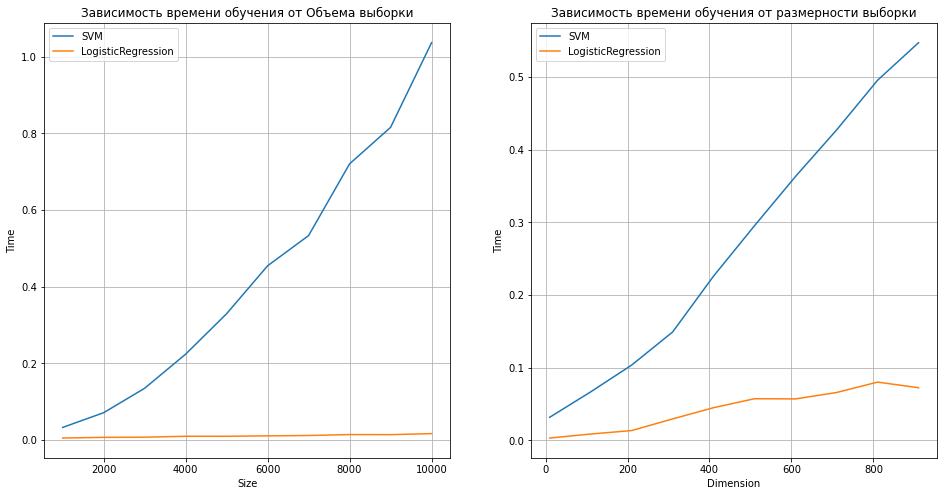

In [28]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(16)    #  ширина и
fig.set_figheight(8)    #  высота "Figure"

axes[0].plot(Svm_time_size.keys(), Svm_time_size.values(), label='SVM')
axes[0].plot(Log_time_size.keys(), Log_time_size.values(), label='LogisticRegression')

axes[1].plot(Svm_time_dim.keys(), Svm_time_dim.values(), label='SVM')
axes[1].plot(Log_time_dim.keys(), Log_time_dim.values(), label='LogisticRegression')

axes[0].set_xlabel('Size')
axes[1].set_xlabel('Dimension')
for ax in axes:
    ax.legend()
    ax.grid()
    
    ax.set_ylabel('Time')
    
    
axes[0].set_title("Зависимость времени обучения от Объема выборки")
axes[1].set_title("Зависимость времени обучения от размерности выборки")


plt.show()

**Вывод:** Видно, что с ростом объема и размерности выборки время обучения SVM значительно увеличивается, а время обучения Логистической регрессии растет сильно медленнее, если это можно назвать ростом

# 6. Уменьшение размерности входа (4 балла)

Если уменьшение числа объектов сложная и зачастую невозможная задача, то
    для понижения числа признаков существует стандартное решение. В предыдущих заданиях Вы уже сталкивались с l1-регуляризацией, которая позволяла уменьшить число признаков в задаче линейной классификации/регрессии. Однако для большинства ML-алгоритмов такой способ уменьшения числа признаков неприменим.
    
   Зато существует стандартное для всех алгоритмов понижение размерности входа. Данный алгоритм называется Principal Component Analysis (PCA, метод главных компонент). Он находит подпространство требуемой размерности $k$ ($k << d$, где d изначальная размерность входа), максимально сохраняющую дисперсию выборки, или, что то же самое, - сумма квадратов длин проекций объектов на которое будет минимальна. Подробнее об этом можете почитать тут https://scikit-learn.org/stable/modules/decomposition.html#pca. 
    
   **Эксперимент:** Проекция в очень малое число координат сильно "упрощает" выборку, из-за чего качество решения задачи может в итоге упасть. **В следующем эксперименте предлагается исследовать зависимость скорости работы метода и качества решения задачи при использовании понижения размерности. Требуется построить два графика:**

1. График зависимости времени работы всего цикла обучения от числа признаков $k$, которое остается после применения PCA. 
2. График зависимости качества решения (accuracy) задачи классификации от числа признаков $k$, которое остается после применения PCA.
    
При этом под полным циклом обучения подразумевается обучение PCA + обучение SVM. Данные для обучения: первые две координаты - луны, которые были в первом задании, а остальные координаты, случайные. 
Таким образом, без понижения размерности SVM с rbf ядром должен иметь точность близкую к 100\%. Чтобы лучше
видеть эффект на графиках, можете менять размер генерируемой выборки. Для данных размеров $k$ рекомендуется перебирать от 10 до 500 (тогда будет видна требуемая закономерность). 
    
   **P.S. Не забывайте делить выборку на обучение и валидацию в этом эксперименте** (так как мы смотрим на качество, мы хотим считать его честно). При этом PCA как и любой другой алгоритм ML тоже нельзя учить на тесте. Общая схема применения PCA описана в ячейках ниже. 

In [29]:
X_moons, y_moons = make_moons_cls(2000, 1000)

In [30]:
X_moons.shape

(2000, 1000)

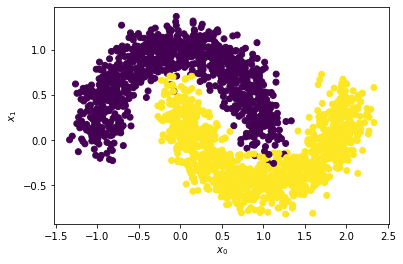

In [31]:
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons)
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.show()

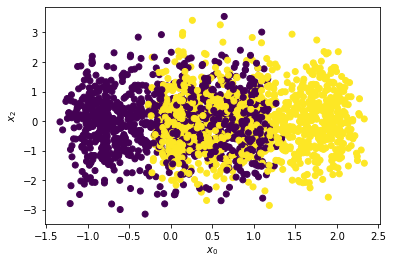

In [32]:
plt.scatter(X_moons[:, 0], X_moons[:, 2], c=y_moons)
plt.xlabel('$x_0$')
plt.ylabel('$x_2$')
plt.show()

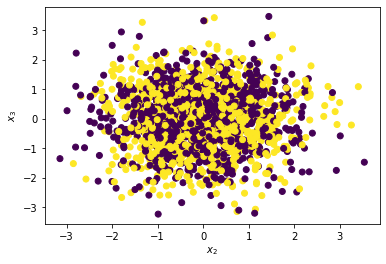

In [33]:
plt.scatter(X_moons[:, 2], X_moons[:, 3], c=y_moons)
plt.xlabel('$x_2$')
plt.ylabel('$x_3$')
plt.show()

Казалось бы понизить размерность в этой задаче достаточно легко, нужно просто выбрать только первые две координаты. Однако из-за нелинейности разделяющей поверхности, для PCA это задача нетривиальна. Такая же ситуация наблюдается и в большинстве прикладных задач. Теперь переходите **к эксперименту** :)

In [34]:
# Пример правильного обучения PCA с делением на train/test
pca_model = PCA(n_components=500)

X_moons_train, X_moons_test, y_moons_train, y_moons_test = train_test_split(
    X_moons, y_moons, test_size=0.2) # делим выборку на трейн тест для оценки качества всего алгоритма

X_train_for_pca, X_train_for_svc, y_train_for_pca, y_train_for_svc = train_test_split(
    X_moons_train, y_moons_train, test_size=0.5) # делим выборку на трейн тест для оценки качества всего алгоритма

print(X_moons.shape, y_moons.shape)
print(X_moons_train.shape, y_moons_train.shape)
print(X_train_for_pca.shape, y_train_for_pca.shape)

# Учим PCA
pca_model.fit(X_train_for_pca)

# Применяем PCA
X_moons_test_transformed = pca_model.transform(X_moons_test)
X_train_for_svc_transformed = pca_model.transform(X_train_for_svc)

print(X_train_for_svc_transformed.shape)

# Учим SVC (на другой выборке чтобы не переобучиться)
svc_on_transformed = SVC(kernel='rbf')
svc_on_transformed.fit(X_train_for_svc_transformed, y_train_for_svc)

preds = svc_on_transformed.predict(X_moons_test_transformed)

print('Accuracy after PCA:', accuracy_score(preds, y_moons_test))

(2000, 1000) (2000,)
(1600, 1000) (1600,)
(800, 1000) (800,)
(800, 500)
Accuracy after PCA: 0.5725


In [35]:
# Your code here

fit_time = {}
quality = {}
for k in range(10,501):
    pca_model = PCA(n_components=k)
    svc_on_transformed = SVC(kernel='rbf')
    
    #Замер времени
    time_start = time.time()
   
    # Учим PCA
    pca_model.fit(X_train_for_pca)

    # Применяем PCA
    X_moons_test_transformed = pca_model.transform(X_moons_test)
    X_train_for_svc_transformed = pca_model.transform(X_train_for_svc)

    # Учим SVC (на другой выборке чтобы не переобучиться)
    svc_on_transformed.fit(X_train_for_svc_transformed, y_train_for_svc)
    
    preds = svc_on_transformed.predict(X_moons_test_transformed)

    fit_time[k] =  time.time() - time_start
    quality[k]= accuracy_score(preds, y_moons_test)
    


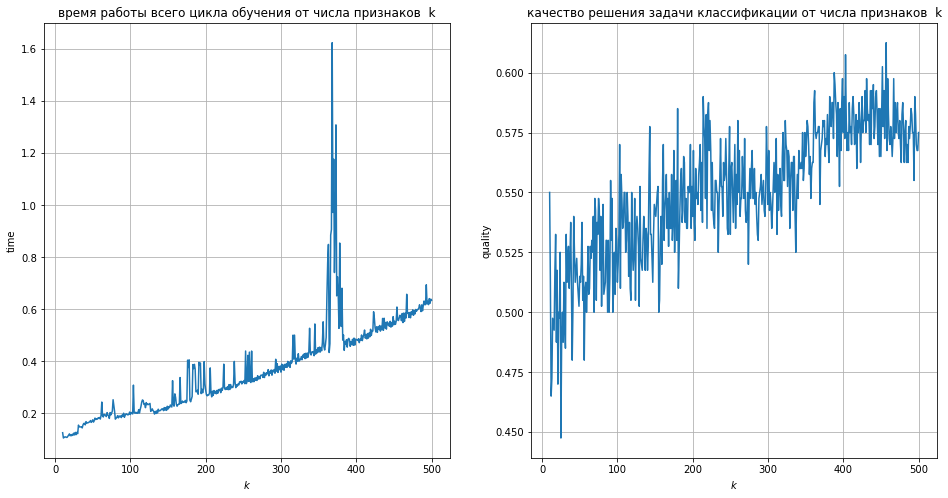

In [36]:
#Графики
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(16)    #  ширина и
fig.set_figheight(8)    #  высота "Figure"

axes[0].plot(fit_time.keys(), fit_time.values())
axes[0].set_ylabel('time')
axes[0].set_title("время работы всего цикла обучения от числа признаков  k")

axes[1].plot(quality.keys(), quality.values())
axes[1].set_ylabel('quality')
axes[1].set_title("качество решения задачи классификации от числа признаков  k")

for ax in axes:
    ax.grid()
    ax.set_xlabel('$k$')
    
plt.show()


Опишите в выводе как ведет себя качество решения задачи и время работы в зависимости от числа компонент в PCA.  

**Вывод:** качество и время растет. время растет, потому что растет размерность признакового пространства, а качество, потому что учимся на говноданных и проверяем на том же

# 7. Калибровка вероятностей (3 балла)

Иногда в задаче классификации важно знать уверенность отнесения к тому или иному классу. В SVM за это отвечает параметр отступа model.decision_function(X). Однако по нему сложно утверждать с какой вероятностью объект относится к тому или иному классу.

Чтобы это понять давайте визуализируем, как соотносится сортировка объектов по отступам с сортировкой
по таргету (классу). То есь построим кривую, в которой по оси X - доля выборки с отступом, меньшим чем данный,
по оси Y - доля объектов класса 1 с отступом, меньшим чем данный среди всех объектов класса 1.   

In [37]:
from sklearn.datasets import make_classification
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression

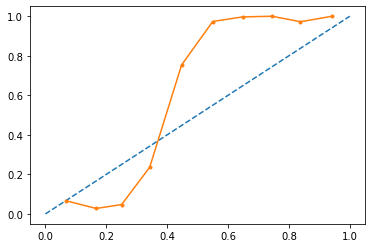

In [38]:

# generate 2 class dataset
X, y = make_classification(n_samples=5000, n_classes=2, weights=[1,1], random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# fit a model
model = SVC()
model.fit(trainX, trainy)
# predict probabilities
probs = model.decision_function(testX)
# reliability diagram
fop, mpv = calibration_curve(testy, probs, n_bins=10, normalize=True)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.')
plt.show()

Вот мы и увидели проблему, линия отступов не ложится на пунктирную линию, что означает что оступы не соотвествуют реальным вероятностям отнесения к тому или иному классу.  

   Для этого существует такая процедура как калибровка вероятностей, при которой отступ для каждого объекта преобразовывается таким образом, чтобы соответствовать вероятности класса. После такого преобразования, полученное число становится интерпретируемой мерой уверенности модели. 

В данном задании Вам прелагается обучить логистическую регрессию на отступах модели, которая по оступу предсказывала бы класс. Именно вероятности этой калибровочной модели и будут нашими верными оценками вероятности класса для объекта:

$p(y_i | x_i) = p(y_i | margin_i)$

Для этого Вам потребуется написать несложный класс CalibratingLogisticRegression. И проверить что новые предсказания дают правильную калибровочную кривую

In [39]:
class CalibratingLogisticRegression:
    def fit(self, x, y):
        assert len(x.shape) == 1 or x.shape[1] == 1
        # Your code here
        self.log_clf = LogisticRegression(solver='lbfgs')
        self.log_clf.fit(x, y)
        
    def predict_proba(self, x):
        assert len(x.shape) == 1 or x.shape[1] == 1
        # Your code here
        return self.log_clf.predict_proba(x)
        

Калибровочную модель и исходную модель нельзя учить на одних и тех же данных, чтобы избежать переобучения. (распределение отступов на обучении и тестовой выборке, скорее всего очень сильно отличается)

In [40]:
model = SVC()
N = len(trainX) // 2
model.fit(trainX[:N], trainy[:N])

SVC()

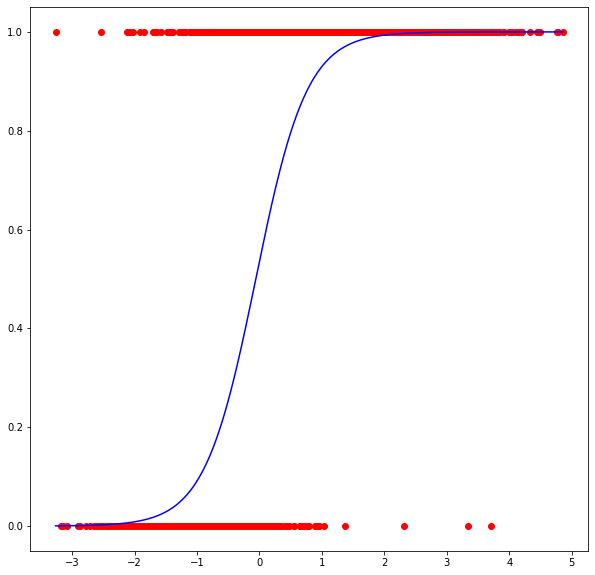

In [41]:
X_features_for_calibrating_model = trainX[N:]


# Учим калибровочную модель на второй половине данных
calibrating_model = CalibratingLogisticRegression()

#отступы для второй половины данных
margin_for_calibrating = model.decision_function(X_features_for_calibrating_model).reshape(-1,1)

#калибруем для этих отступов наш КАЛИБРАТОР
calibrating_model.fit(margin_for_calibrating, trainy[N:])

#отступы тестовых данных
margin = model.decision_function(testX)

#вероятности принадлежности 1ому классу по отступам тестовых данных
prob = calibrating_model.predict_proba(margin.reshape(-1,1))[:, 1]


# Как это выглядит на обучении
margin_sorted, probs_sorted_by_margin = zip(*sorted(zip(margin, prob)))
plt.figure(figsize=(10, 10))
plt.plot(margin, testy, 'ro')
plt.plot(margin_sorted, probs_sorted_by_margin, 'b')
plt.show()

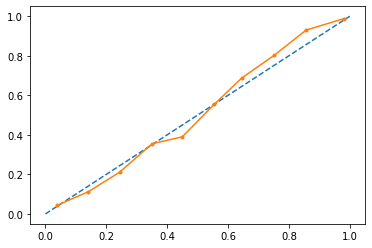

In [42]:
probs = calibrating_model.predict_proba(model.decision_function(testX).reshape(-1,1))[:,1]
# reliability diagram
fop, mpv = calibration_curve(testy, probs, n_bins=10, normalize=True)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
plt.plot(mpv, fop, marker='.')
plt.show()

Сделайте выводы о полученной модели. В каких задачах калибровка вероятностей могла бы быть полезной?

**Выводы:** ну ля, легло почти как надо, значит хорошо предсказывает вероятности по отступам. Может пригодиться в задачах бизнеса, где от точности вероятности зависит прибыльность предприятия. Ну или вероятность дождя еще полезно предсказать, тоже важно, если намылился куда-нить с мадамой. 

# Бонусное задание (2 балла)

Найдите мем про SVM лучше чем этот:

![texte](https://clck.ru/YyDTf)

Вставьте его внешней ссылкой и проверьте, что в сгенерированном html он отображается


![texte](https://sun9-78.userapi.com/impg/tmNyU3IpXuBeF2RkXF4y2FJ2khDbcG8T0UWGmQ/aA9O-2ZdQaw.jpg?size=2048x1024&quality=95&sign=ad71885a212f5f111de885a79191c5b5&type=album)

**Перед тем, как сдать ноутбук на кросс-рецензирование, мы рекомендуем перезапустить ядро и выполнить весь ноутбук (cell -> run all). При правильном выполнении весь процесс работы ноутбука не должен занять больше 20 минут**